### A Machine learning approach to identify spurious GPS readings



In [8]:
%run "../common-WadeCopy1.ipynb"

#fileName="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=WITH rows AS (SELECT *,ROW_NUMBER() OVER (ORDER BY mobile_id, id DESC) AS rn FROM loc WHERE (record_type <> 'active' OR record_type IS NULL)) SELECT * FROM rows loc1 WHERE (loc1.rn,loc1.mobile_id)  IN ((SELECT loc2.rn, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-1, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B1, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-2, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B2, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-3, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B3, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) )&type=html";
#fileName="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=WITH%20rows%20AS%20%28SELECT%20*,ROW_NUMBER%28%29%20OVER%20%28ORDER%20BY%20mobile_id,%20id%20DESC%29%20AS%20rn%20FROM%20loc%20WHERE%20%28record_type%20%3C%3E%20%27active%27%20OR%20record_type%20IS%20NULL%29%29%20SELECT%20*%20FROM%20rows%20loc1%20WHERE%20id%20%3E%2024600%20AND%20%28record_type%20%3C%3E%20%27active%27%20OR%20%20record_type%20IS%20null%29&type=html";
fileNameinvalid="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=WITH%20rows%20AS%20%28SELECT%20*,ROW_NUMBER%28%29%20OVER%20%28ORDER%20BY%20mobile_id,%20id%20DESC%29%20AS%20rn%20FROM%20loc%20WHERE%20%28record_type%20%3C%3E%20%27active%27%20OR%20record_type%20IS%20NULL%29%29%20SELECT%20*%20FROM%20rows%20loc1%20WHERE%20%28loc1.rn,loc1.mobile_id%29%20%20IN%20%28%28SELECT%20loc2.rn,%20loc2.mobile_id%20FROM%20rows%20loc2%20WHERE%20loc2.is_valid%20!=%201%29%20UNION%20%28SELECT%20loc2.rn-1,%20loc2.mobile_id%20FROM%20rows%20loc2%20WHERE%20loc2.is_valid%20!=%201%29%20UNION%20%28SELECT%20loc2.rn%2B1,%20loc2.mobile_id%20FROM%20rows%20loc2%20WHERE%20loc2.is_valid%20!=%201%29%20%29&type=html";
fileNamevalid="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=WITH%20rows%20AS%20%28SELECT%20*,ROW_NUMBER%28%29%20OVER%20%28ORDER%20BY%20mobile_id,%20id%20DESC%29%20AS%20rn%20FROM%20loc%20WHERE%20id%3C%2040016%20AND%20id%20%3E%2024599%20AND%20%28record_type%20%3C%3E%20%27active%27%20OR%20record_type%20IS%20NULL%29%29%20SELECT%20*%20FROM%20rows%20loc1%20WHERE%20%28record_type%20%3C%3E%20%27active%27%20OR%20%20record_type%20IS%20null%29%20LIMIT%2010000&type=html";
#fileName = fileName.replace(' ', '%20')
dfOriginalinvalid = LoadDataSet(fileNameinvalid, columns=None, checkForDateTime=False);
dfOriginalvalid = LoadDataSet(fileNamevalid, columns=None, checkForDateTime=False);



In [9]:
from datetime import datetime,timedelta
# Prepare dataset
#
# 1. Drop columns we don't need
# 2. Convert column datatypes as needed; to string, datetime, numbers as needed
# 3. Add Calculated Columns
# 4. Filter out rows and reindex the dataframe
# 5. Display the resulting dataframe
# 6. Show some descriptive statistics

#=====
#1. "ProcessedDateId" column is Intentionally misspelled to show it goes undetected if not careful

columns = '''
id, 
stored_at, measured_at, is_valid, api_key, version, record_type, session_num, 
mobile_id, user_id, caller_ip, 
lat, lon, accuracy, speed, bearing, alt, device_temp, device_pressure, device_humidity, device_light, medication, 
weather_time, temperature_min, temperature_max, humidity, no2, pressure, wind, clouds_sky, notes, attr, the_geom, 
location, activity, battery_level, rn"
'''
toDrop= [k.strip() for k in ''' api_key, version,  session_num, 
mobile_id, 
user_id, 
caller_ip, device_temp, device_pressure, device_humidity, device_light, medication, weather_time, 
temperature_min, temperature_max, humidity, no2, pressure, wind, clouds_sky, notes, attr, 
the_geom,weatherchecked,pef,fev,

'''.split(",")]
dfLvalid = dfOriginalvalid.drop(toDrop, axis=1, errors="ignore")
dfLinvalid = dfOriginalinvalid.drop(toDrop, axis=1, errors="ignore")


##1a -> Set the Prediction column
##   -> Set class names if you know it or make it None
predictColumn = "is_valid"
class_names = ["Inalid", "Valid"]

##2. Some wrong dates causing error here - so lets treat this as str
dfLvalid[predictColumn] = dfLvalid[predictColumn].astype(str)    # Treat this columns as string
dfLinvalid[predictColumn] = dfLinvalid[predictColumn].astype(str)    # Treat this columns as string
#dfL[u'ProcessedDateId']   = dfL[u'ProcessedDateId'].astype(str)      # Treat this columns as string (intentionally included)


#Sorted version for mapping
#dfL2 = dfL

#DEBUG For printing entire Data Frame
#pd.set_option('display.max_rows', len(dfL['is_valid']))
#print(dfL)
#pd.reset_option('display.max_rows')


##3. Calculated columns
#dfL[u'DBKLag'] = dfL[u'DBKLag']/60                                   # lets divide this by 60 
#dfL[u'DBKLag'] = dfL.DBKLag.apply(abs)                               # Convert to absolute value 




usedvalids = []
usedinvalids = []

stored_at = []
measured_at = []
is_valid = []
record_type = []
lat = []
lon = []
accuracy = []
speed = []
bearing = []
alt = []
location = []
activity = []
battery_level = []
rn = []

previousinvalids = []
secfromprev = []
sectonext = []
distfromprev = []
disttonext = []
spdfromprev = []
spdtonext = []
angle = []

#print(range(dfL['is_valid'].value_counts()['2']))
#print(dfL['is_valid'][dfL['is_valid']=='2'].index[0])
#print(dfL.loc[dfL['is_valid'] == '2', :])
#print(len(dfLvalid))
#print(random.randint(0, len(dfL)-1))
numtimesinvalid = {}

for k in range(dfLinvalid['is_valid'].value_counts()['2']):
    
    invalididx = dfLinvalid['is_valid'][dfLinvalid['is_valid']=='2'].index[k]
    curlat = dfLinvalid['lat'][invalididx]
    curlon = dfLinvalid['lon'][invalididx]
        
    key = str(curlat) + ', ' + str(curlon)
    if key in numtimesinvalid:
        numtimesinvalid[key] += 1
    else:
        numtimesinvalid[key] = 1
        
#print(numtimesinvalid)
        
for k in range(dfLinvalid['is_valid'].value_counts()['2']):
    #CALCULATE INFO FOR INVALID POINT
    
    invalididx = dfLinvalid['is_valid'][dfLinvalid['is_valid']=='2'].index[k]
    if invalididx == 0 or invalididx == len(dfLinvalid[predictColumn])-1:
        continue    
    elif dfLinvalid['rn'][invalididx]-1 == dfLinvalid['rn'][invalididx-1] and dfLinvalid['rn'][invalididx]+1 == dfLinvalid['rn'][invalididx+1] and dfLinvalid['is_valid'][invalididx-1] == '1' and dfLinvalid['is_valid'][invalididx+1] == '1':
        usedinvalids.append(invalididx)
        stored_at.append(dfLinvalid['stored_at'][invalididx])
        measured_at.append(dfLinvalid['measured_at'][invalididx])
        is_valid.append(dfLinvalid['is_valid'][invalididx])
        record_type.append(dfLinvalid['record_type'][invalididx])
        lat.append(dfLinvalid['lat'][invalididx])
        lon.append(dfLinvalid['lon'][invalididx])
        accuracy.append(dfLinvalid['accuracy'][invalididx])
        speed.append(dfLinvalid['speed'][invalididx])
        bearing.append(dfLinvalid['bearing'][invalididx])
        alt.append(dfLinvalid['alt'][invalididx])
        location.append(dfLinvalid['location'][invalididx])
        activity.append(dfLinvalid['activity'][invalididx])
        battery_level.append(dfLinvalid['battery_level'][invalididx])
        rn.append(dfLinvalid['rn'][invalididx])
        
        curdatetime = datetime.strptime(dfLinvalid['measured_at'][invalididx].split('.')[0],'%Y-%m-%d %H:%M:%S')
        prevdatetime = datetime.strptime(dfLinvalid['measured_at'][invalididx+1].split('.')[0],'%Y-%m-%d %H:%M:%S')
        nextdatetime = datetime.strptime(dfLinvalid['measured_at'][invalididx-1].split('.')[0],'%Y-%m-%d %H:%M:%S')
        
        #seconds from previous
        secfromprev.append((curdatetime - prevdatetime).seconds)
        
        
        #seconds to next
        sectonext.append((nextdatetime-curdatetime).seconds)
        
        
        curlat = dfLinvalid['lat'][invalididx]
        curlon = dfLinvalid['lon'][invalididx]
        
        key = str(curlat) + ', ' + str(curlon)
        if key in numtimesinvalid:
            previousinvalids.append(numtimesinvalid[key])
        else:
            previousinvalids.append(0)
        
        #print(str(curlat) +', '+ str(curlon))
        
        nextlat = dfLinvalid['lat'][invalididx-1]
        nextlon = dfLinvalid['lon'][invalididx-1]
        
        prevlat = dfLinvalid['lat'][invalididx+1]
        prevlon = dfLinvalid['lon'][invalididx+1]
        
        #miles to next
        disttonext.append(math.sqrt(69.1*(curlat-nextlat)*69.1*(curlat-nextlat)+(69.1*(curlon - nextlon)*cos(nextlat/57.3))*(69.1*(curlon - nextlon)*cos(nextlat/57.3))))
        #print(disttonext[k])
        
        #miles from prev
        distfromprev.append(math.sqrt(69.1*(curlat-prevlat)*69.1*(curlat-prevlat)+(69.1*(curlon - prevlon)*cos(prevlat/57.3))*(69.1*(curlon - prevlon)*cos(prevlat/57.3))))
        #print(distfromprev[k])
        
        
        
        #Speed in MPH to next
        if sectonext[len(sectonext)-1] != 0:
            spdtonext.append(disttonext[len(disttonext)-1]/(sectonext[len(sectonext)-1]/3600))
        else:
            spdtonext.append(None)
        #print(spdtonext[k])
        
        #Speed in MPH from prev
        if secfromprev[len(secfromprev)-1] != 0:
            spdfromprev.append(distfromprev[len(distfromprev)-1]/(secfromprev[len(secfromprev)-1]/3600))
        else:
            spdfromprev.append(None)
        #print(spdfromprev[k])
        
        #Angle in degrees between previous point, next point, and current point
        if distfromprev[len(distfromprev)-1]*disttonext[len(disttonext)-1] != 0:
            distancebetweennextandprev = math.sqrt(69.1*(prevlat-nextlat)*69.1*(prevlat-nextlat)+(69.1*(prevlon - nextlon)*cos(nextlat/57.3))*(69.1*(prevlon - nextlon)*cos(nextlat/57.3)))
            lawofcos = (math.pow(distancebetweennextandprev,2) - math.pow(distfromprev[len(distfromprev)-1],2) - math.pow(disttonext[len(disttonext)-1],2))/(-2*distfromprev[len(distfromprev)-1]*disttonext[len(disttonext)-1])
            if lawofcos < -1:
                lawofcos = -1
            if lawofcos > 1:
                lawofcos = 1
            angle.append((180/math.pi)*math.acos(lawofcos))
        else:
            angle.append(None)
        #print(angle[k])

for k in range(len(usedinvalids)):
    #FIND A RANDOM VALID POINT THAT HAS VALID ON BOTHS SIDES OF IT
    randvalid = random.randint(1, len(dfLvalid)-2)
    while(randvalid in usedvalids or dfLvalid['is_valid'][randvalid] != '1' or (dfLvalid['rn'][randvalid+1] != dfLvalid['rn'][randvalid]+1) or (dfLvalid['rn'][randvalid-1] != dfLvalid['rn'][randvalid]-1) or dfLvalid['is_valid'][randvalid+1] != '1' or dfLvalid['is_valid'][randvalid-1] != '1'):
        randvalid = random.randint(1, len(dfLvalid)-2)
    
    usedvalids.append(randvalid)
    
    #FIND INFO FOR VALID POINT
    stored_at.append(dfLvalid['stored_at'][randvalid])
    measured_at.append(dfLvalid['measured_at'][randvalid])
    is_valid.append(dfLvalid['is_valid'][randvalid])
    record_type.append(dfLvalid['record_type'][randvalid])
    lat.append(dfLvalid['lat'][randvalid])
    lon.append(dfLvalid['lon'][randvalid])
    accuracy.append(dfLvalid['accuracy'][randvalid])
    speed.append(dfLvalid['speed'][randvalid])
    bearing.append(dfLvalid['bearing'][randvalid])
    alt.append(dfLvalid['alt'][randvalid])
    location.append(dfLvalid['location'][randvalid])
    activity.append(dfLvalid['activity'][randvalid])
    battery_level.append(dfLvalid['battery_level'][randvalid])
    rn.append(dfLvalid['rn'][randvalid])
        
    curdatetime = datetime.strptime(dfLvalid['measured_at'][randvalid].split('.')[0],'%Y-%m-%d %H:%M:%S')
    prevdatetime = datetime.strptime(dfLvalid['measured_at'][randvalid+1].split('.')[0],'%Y-%m-%d %H:%M:%S')
    nextdatetime = datetime.strptime(dfLvalid['measured_at'][randvalid-1].split('.')[0],'%Y-%m-%d %H:%M:%S')
        
    #seconds from previous
    secfromprev.append((curdatetime - prevdatetime).seconds)
        
        
    #seconds to next
    sectonext.append((nextdatetime-curdatetime).seconds)
        
        
    curlat = dfLvalid['lat'][randvalid]
    curlon = dfLvalid['lon'][randvalid]
    
    key = str(curlat) + ', ' + str(curlon)
    if key in numtimesinvalid:
        previousinvalids.append(numtimesinvalid[key])
    else:
        previousinvalids.append(0)
        
        
    nextlat = dfLvalid['lat'][randvalid-1]
    nextlon = dfLvalid['lon'][randvalid-1]
        
    prevlat = dfLvalid['lat'][randvalid+1]
    prevlon = dfLvalid['lon'][randvalid+1]
        
    #miles to next
    disttonext.append(math.sqrt(69.1*(curlat-nextlat)*69.1*(curlat-nextlat)+(69.1*(curlon - nextlon)*cos(nextlat/57.3))*(69.1*(curlon - nextlon)*cos(nextlat/57.3))))
    #print(disttonext[k])
        
    #miles from prev
    distfromprev.append(math.sqrt(69.1*(curlat-prevlat)*69.1*(curlat-prevlat)+(69.1*(curlon - prevlon)*cos(prevlat/57.3))*(69.1*(curlon - prevlon)*cos(prevlat/57.3))))
    #print(distfromprev[k])
        
        
        
    #Speed in MPH to next
    if sectonext[len(sectonext)-1] != 0:
        spdtonext.append(disttonext[len(disttonext)-1]/(sectonext[len(sectonext)-1]/3600))
    else:
        spdtonext.append(None)
    #print(spdtonext[k])
        
    #Speed in MPH from prev
    if secfromprev[len(secfromprev)-1] != 0:
        spdfromprev.append(distfromprev[len(distfromprev)-1]/(secfromprev[len(secfromprev)-1]/3600))
    else:
        spdfromprev.append(None)
    #print(spdfromprev[k])
        
    #Angle in degrees between previous point, next point, and current point
    if distfromprev[len(distfromprev)-1]*disttonext[len(disttonext)-1] != 0:
        distancebetweennextandprev = math.sqrt(69.1*(prevlat-nextlat)*69.1*(prevlat-nextlat)+(69.1*(prevlon - nextlon)*cos(nextlat/57.3))*(69.1*(prevlon - nextlon)*cos(nextlat/57.3)))
        lawofcos = (math.pow(distancebetweennextandprev,2) - math.pow(distfromprev[len(distfromprev)-1],2) - math.pow(disttonext[len(disttonext)-1],2))/(-2*distfromprev[len(distfromprev)-1]*disttonext[len(disttonext)-1])
        if lawofcos < -1:
            lawofcos = -1
        if lawofcos > 1:
            lawofcos = 1
        angle.append((180/math.pi)*math.acos(lawofcos))
    else:
        angle.append(None)
    #print(angle[k])
    
    
  

newdict = {'stored_at': stored_at,
'measured_at': measured_at,
'is_valid': is_valid,
'record_type': record_type,
#'lat': lat,
#'lon': lon,
'accuracy': accuracy,
'speed': speed,
'bearing': bearing,
'alt': alt,
'location': location,
'activity': activity,
'battery_level': battery_level,
#'rn': rn,
'secfromprev': secfromprev,
'sectonext': sectonext,
'distfromprev': distfromprev,
'disttonext': disttonext,
'spdfromprev': spdfromprev,
'spdtonext': spdtonext,
'angle': angle,
'previousinvalids': previousinvalids}

dfLnew = pd.DataFrame(newdict)
dfL = dfLnew



#pd.set_option('display.max_rows', len(dfL['is_valid']))
#print(dfLnew)
#pd.reset_option('display.max_rows')

#print(dfL['rn'][dfL['is_valid']=='2'])


        
##4. Filter rows
n1 = dfL.shape[0]
#dfL = dfL[dfL.DBKLag > 1]                                            # Lets take only those that have a value > 0 
#
## Here are other common filtering you may use:
# dfL = dfL[dfL['OEMModel'] == "Surface Pro 4"]
# dfL = dfL[dfL.OSVersionFull.str.contains("th1") | dfL.OSVersionFull.str.contains("th2")]
# dfL = dfL[dfL.is_valid == '2'-1 | dfL.is_valid == '2' | dfL.is_valid == '2'+1]
#print(dfL[dfL.is_valid == '2'-1 | dfL.is_valid == '2' | dfL.is_valid == '2'+1])
#print(dfL.is_valid[1:] == '2' dfL.is_valid == '2' or dfL.is_valid[:1] == '2')
#pd.set_option('display.max_rows', len(dfL['is_valid']))
#print(dfL)
#pd.reset_option('display.max_rows')

n2 = dfL.shape[0]
print ("Filtering: Number of rows Before {} and After {}".format(n1,n2));

#4a. You may reshuffle the rows if needed to make sure they are not in any particular order
dfL = dfL.sample(frac=1).reset_index(drop=True)

#4b. 
# Once you filter, it is a good idea to reindex such that 0th row matches to 0th row in the resulting dataframe
# To see what happens if you didn't to reindex, comment out the following code and notice index 1 and 3 are visibly missing 

dfL = dfL.reset_index(drop=True) 

#5.
displayDFs(dfL, showIcons=True, showStats=True, maxrows = 4) 

# You can see the entire dataframe by using the following
# HTML(dfL.to_html())

Filtering: Number of rows Before 178 and After 178


count,178.000,178,178.000,161.000,0.000,178.000,178.000,178.000,178,0.000,178,178.000,178,178.000,178.000,171.000,168.000,178.000,178
unique,-,1,-,-,0.000,-,-,-,2,0.000,178,-,5,-,-,-,-,-,178
top,-,null,-,-,-,-,-,-,1,-,2016-04-24 19:11:28.0,-,gps,-,-,-,-,-,2016-05-06 05:26:18.059889
freq,-,178,-,-,-,-,-,-,89,-,1,-,127,-,-,-,-,-,1
mean,561.627,-,59.320,62.224,-,61.673,0.257,0.301,-,-,-,7.258,-,867.848,1501.466,17.478,21.502,4.685,-
std,726.003,-,235.273,72.806,-,108.847,0.619,0.871,-,-,-,13.170,-,2478.042,4685.311,28.462,48.283,9.470,-
min,3.000,-,-67.000,0.000,-,0.000,0.000,0.000,-,-,-,0.000,-,0.000,0.000,0.007,0.004,0.000,-
25%,20.268,-,0.000,0.573,-,0.000,0.039,0.039,-,-,-,0.000,-,17.500,17.500,1.149,0.956,0.000,-
50%,66.179,-,0.000,17.682,-,0.000,0.168,0.157,-,-,-,1.000,-,93.000,72.000,4.280,4.626,0.000,-
75%,1000.000,-,36.750,142.375,-,74.250,0.228,0.228,-,-,-,4.000,-,388.750,494.500,20.158,24.632,1.188,-
max,2955.000,-,1883.000,179.724,-,354.000,7.093,8.945,-,-,-,34.000,-,14382.000,43591.000,234.256,466.159,34.610,-


### Descriptive Statistics

In [10]:
#Wade can you find a way to plot the points on a map here!

# Given three consecutive readings from a GPS system (p1, p2, p3), is it possible to detect if p2 is invalid?
# or Give a set of points p1 .. pn, detect all invalid readings!

import folium





#pd.set_option('display.max_rows', len(dfL2['is_valid']))
#print(dfL2)
#pd.reset_option('display.max_rows')


map1 = folium.Map(location=(47.643, -122.129) , zoom_start=14)

for k in range(len(usedvalids)):
    if dfLvalid['is_valid'][usedvalids[k]] == '1':
        #Valid Points Blue
        fcolor = '#0000FF'
    else:
        #Invalid Points Red
        fcolor = '#FF0000'
    
    #map1.circle_marker(location=[dfL['lat'][k], dfL['lon'][k]], radius=500, line_color='#000000',fill_color=fcolor)
    folium.CircleMarker([dfLvalid['lat'][usedvalids[k]], dfLvalid['lon'][usedvalids[k]]],
                    radius=7,
                    color=fcolor,
                    fill_color=fcolor,
                   ).add_to(map1)
    folium.CircleMarker([dfLvalid['lat'][usedvalids[k]-1], dfLvalid['lon'][usedvalids[k]-1]],
                    radius=7,
                    color=fcolor,
                    fill_color=fcolor,
                   ).add_to(map1)
    folium.CircleMarker([dfLvalid['lat'][usedvalids[k]+1], dfLvalid['lon'][usedvalids[k]+1]],
                    radius=7,
                    color=fcolor,
                    fill_color=fcolor,
                   ).add_to(map1)
    
    map1.line([[dfLvalid['lat'][usedvalids[k]],dfLvalid['lon'][usedvalids[k]]],[dfLvalid['lat'][usedvalids[k]+1],dfLvalid['lon'][usedvalids[k]+1]]], line_color='#000000', line_weight=1)
    map1.line([[dfLvalid['lat'][usedvalids[k]],dfLvalid['lon'][usedvalids[k]]],[dfLvalid['lat'][usedvalids[k]-1],dfLvalid['lon'][usedvalids[k]-1]]], line_color='#000000', line_weight=1)
    

#print(len(usedinvalids))    
for k in range(len(usedinvalids)):
    if dfLinvalid['is_valid'][usedinvalids[k]] == '1':
        #Valid Points Blue
        fcolor = '#0000FF'
    else:
        #Invalid Points Red
        fcolor = '#FF0000'
    
    #map1.circle_marker(location=[dfL['lat'][k], dfL['lon'][k]], radius=500, line_color='#000000',fill_color=fcolor)
    folium.CircleMarker([dfLinvalid['lat'][usedinvalids[k]], dfLinvalid['lon'][usedinvalids[k]]],
                    radius=7,
                    color=fcolor,
                    fill_color=fcolor,
                    popup=dfLinvalid['id'][usedinvalids[k]]
                   ).add_to(map1)
    folium.CircleMarker([dfLinvalid['lat'][usedinvalids[k]-1], dfLinvalid['lon'][usedinvalids[k]-1]],
                    radius=7,
                    color='#0000FF',
                    fill_color='#0000FF',
                   ).add_to(map1)
    folium.CircleMarker([dfLinvalid['lat'][usedinvalids[k]+1], dfLinvalid['lon'][usedinvalids[k]+1]],
                    radius=7,
                    color='#0000FF',
                    fill_color='#0000FF',                    
                   ).add_to(map1)
    
    map1.line([[dfLinvalid['lat'][usedinvalids[k]],dfLinvalid['lon'][usedinvalids[k]]],[dfLinvalid['lat'][usedinvalids[k]+1],dfLinvalid['lon'][usedinvalids[k]+1]]], line_color='#000000', line_weight=1)
    map1.line([[dfLinvalid['lat'][usedinvalids[k]-1],dfLinvalid['lon'][usedinvalids[k]-1]],[dfLinvalid['lat'][usedinvalids[k]],dfLinvalid['lon'][usedinvalids[k]]]], line_color='#000000', line_weight=1)  
    
    #map1.location = [dfL2['lat'][usedinvalids[k]], dfL2['lon'][usedinvalids[k]]]
    #input("Press Enter to continue...")    
    
display(map1)    




/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:44: FutureWarning: line is deprecated. Use add_children(PolyLine) instead
/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:45: FutureWarning: line is deprecated. Use add_children(PolyLine) instead
/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:75: FutureWarning: line is deprecated. Use add_children(PolyLine) instead
/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:76: FutureWarning: line is deprecated. Use add_children(PolyLine) instead


Dropping in prepareDF -  Index(['measured_at', 'stored_at'], dtype='object')


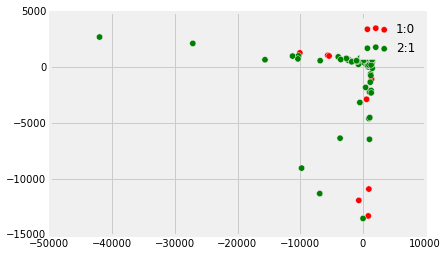

In [11]:
dfPCA=PCAPlot(dfL, predictColumn)

## Predictions

In [12]:
# Lets convert the columns to numeric 
# Please see Prepare in Features.py 

df =  prepareDF(dfL, makeCopy=True)

# Review the resulting final data set;
#df = df.sample(frac=1).reset_index(drop=True)
display(dfL.head(), "==>" ,df.head() )

Dropping in prepareDF -  Index(['measured_at', 'stored_at'], dtype='object')


,accuracy,activity,alt,angle,battery_level,bearing,distfromprev,disttonext,is_valid,location,measured_at,previousinvalids,record_type,secfromprev,sectonext,spdfromprev,spdtonext,speed,stored_at
0,1700.000,null,0.000,68.207,None,0.000,0.506,1.763,2,None,2016-03-14 09:49:36.0,1,gps,60,43591,30.373,0.146,0.000,2016-03-21 12:06:01.947437
1,1000.000,null,0.000,0.390,None,0.000,0.227,0.226,2,None,2016-03-19 09:32:42.0,34,gps,3011,308,0.272,2.639,0.000,2016-03-19 10:42:42.175571
2,1000.000,null,0.000,0.042,None,0.000,0.227,0.227,2,None,2016-04-30 19:10:29.0,34,gps,534,1018,1.529,0.801,0.000,2016-04-30 19:49:32.705225
3,64.500,null,0.000,0.438,None,0.000,7.093,6.992,1,None,2016-04-01 16:36:25.0,0,gps,109,54,234.256,466.159,0.000,2016-04-01 17:41:08.483195
4,1299.999,null,0.000,0.136,None,0.000,0.569,0.570,2,None,2016-03-24 09:22:44.0,1,gps,7231,126,0.283,16.297,0.000,2016-03-24 09:22:44.894693


'==>'

,accuracy,activity,alt,angle,battery_level,bearing,distfromprev,disttonext,is_valid,location,previousinvalids,record_type,secfromprev,sectonext,spdfromprev,spdtonext,speed
0,1700.000,0,0.000,68.207,0,0.000,0.506,1.763,1,0,1,2,60,43591,30.373,0.146,0.000
1,1000.000,0,0.000,0.390,0,0.000,0.227,0.226,1,0,34,2,3011,308,0.272,2.639,0.000
2,1000.000,0,0.000,0.042,0,0.000,0.227,0.227,1,0,34,2,534,1018,1.529,0.801,0.000
3,64.500,0,0.000,0.438,0,0.000,7.093,6.992,0,0,0,2,109,54,234.256,466.159,0.000
4,1299.999,0,0.000,0.136,0,0.000,0.569,0.570,1,0,1,2,7231,126,0.283,16.297,0.000


Feature space holds 178 observations and 16 features
Unique target labels: [1 0]
* 0* 1* 2* 3* 4*
   DecisionTree Gini accuracy: 0.977528 
   DecisionTree Gini r^2 score: 0.910112
* 0* 1* 2* 3* 4*
   DecisionTree Entr accuracy: 0.966292 
   DecisionTree Entr r^2 score: 0.865169
* 0* 1* 2* 3* 4*
                 SVM accuracy: 0.848315 
                 SVM r^2 score: 0.393258
* 0* 1* 2* 3* 4*
       Random Forest accuracy: 0.977528 
       Random Forest r^2 score: 0.910112
* 0* 1* 2* 3* 4*
                K-NN accuracy: 0.859551 
                K-NN r^2 score: 0.438202
* 0* 1* 2* 3* 4*
   Gradient Boosting accuracy: 0.955056 
   Gradient Boosting r^2 score: 0.820225
* 0* 1* 2* 3* 4*
    Logit Regression accuracy: 0.865169 
    Logit Regression r^2 score: 0.460674


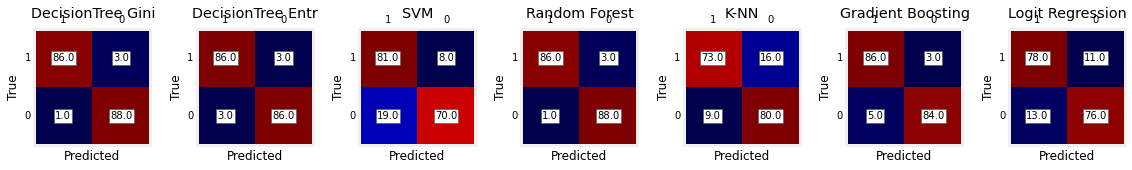

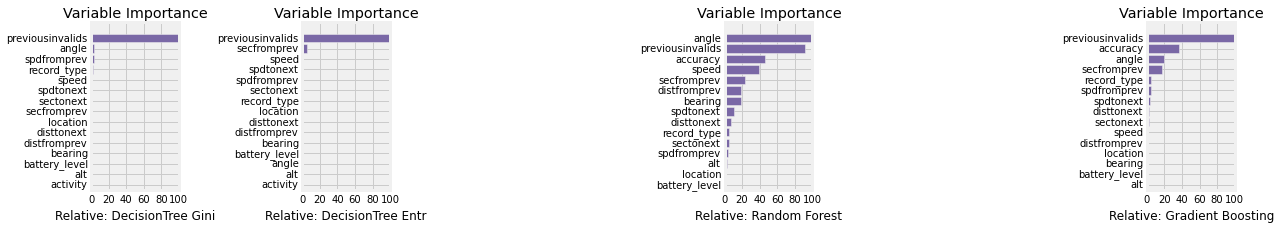

CPU times: user 1.79 s, sys: 17.9 ms, total: 1.81 s
Wall time: 1.82 s


In [18]:
%%time
cls = [# Comment/uncomment out any classfiers according to your need 
       # DO NOT CHANGE
        "DecisionTree Gini" , tree.DecisionTreeClassifier(max_depth=4, criterion="gini"),
        "DecisionTree Entr" , tree.DecisionTreeClassifier(max_depth=4, criterion="entropy"), 
        "SVM"               , sklearn.svm.SVC(), 
        "Random Forest"     , sklearn.ensemble.RandomForestClassifier(),
        "K-NN"              , sklearn.neighbors.KNeighborsClassifier(),
        "Gradient Boosting" , sklearn.ensemble.RandomForestClassifier(),
        "Logit Regression"  , sklearn.linear_model.LogisticRegression()
];

y = df[predictColumn]
X = df.drop(predictColumn, axis=1)
(X1,y1,ra,cls) = Classify(X,y, True, drawConfusionMatrix=True, classifiers=cls, scale=True)


In [15]:
#get_ipython().reset()
decisionTrees = []

for k in range( int (len(cls)/2)) :
    d = cls[k*2+1];
    if (str(type(d)).find('DecisionTreeClassifier') > 0):
        decisionTrees.append(cls[k*2])
        decisionTrees.append(cls[k*2+1])

#d = DrawDecisionTree(X,y, decisionTrees, class_names);

In [17]:
F, pval = sklearn.feature_selection.f_regression(X, y, center=True)
#pd.set_option('display.max_rows', len(dfL))
#print(dfL[['is_valid', 'record_type']])
#pd.reset_option('display.max_rows')  
#print(list(X.columns.values))
#print(pval)

pvaldict = {
    'feature': X.columns.values,
    'fscore': F,
    'pval': pval
}


pvaldf = pd.DataFrame(pvaldict)

#print(pvaldf['pval'])

pd.set_option('display.float_format', '{:.3g}'.format)

pd.set_option('display.max_rows', len(pvaldf))
display(pvaldf.head(len(pvaldf)))
pd.reset_option('display.max_rows')  








,feature,fscore,pval
0,accuracy,153,1.03e-25
1,activity,nan,nan
2,alt,1.99,0.16
3,angle,126,2.44e-22
4,battery_level,nan,nan
5,bearing,41,1.32e-09
6,distfromprev,0.00782,0.93
7,disttonext,0.139,0.71
8,location,nan,nan
9,previousinvalids,74,4.16e-15


In [ ]:
#pd.set_option('display.max_rows', len(dfL))
#print(dfL)
#pd.reset_option('display.max_rows')  